In [ ]:
import sys
sys.path.append('..')

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from src.nn.NonnegativeLinear import NonnegativeLinear1
from src.utils.fix_seed import fix_seed

fix_seed()
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
def function(x):
    return np.square(x) + 1

In [3]:
train_x = np.random.uniform(-1, 1, (64, 1))
train_y = function(train_x)
test_x = np.linspace(-1, 1, 101)
test_y = function(test_x)

train_x = torch.from_numpy(train_x).float().to(DEVICE)
train_y = torch.from_numpy(train_y).float().to(DEVICE)

test_x = torch.from_numpy(test_x).float().to(DEVICE).unsqueeze(dim=-1)

In [4]:
class TestNonnegativeLinear1(NonnegativeLinear1):
    def __init__(self, in_features, out_features, bias = True):
        super(TestNonnegativeLinear1, self).__init__(in_features, out_features, bias)
        self.in_features = in_features
    
    def forward(self, input):
        return nn.functional.linear(input, self.positive_weight, self.in_features * self.bias)

In [5]:
class test1(nn.Module):
    def __init__(self, hidden_dim = 64):
        super(test1, self).__init__()
        self.layer = nn.Sequential(nn.Linear(1, hidden_dim),
                                   nn.LeakyReLU(negative_slope=0.5),
                                   NonnegativeLinear1(hidden_dim, hidden_dim),
                                   nn.LeakyReLU(negative_slope=0.5),
                                   NonnegativeLinear1(hidden_dim, hidden_dim),
                                   nn.LeakyReLU(negative_slope=0.5),
                                   NonnegativeLinear1(hidden_dim, 1),
                                   nn.LeakyReLU(negative_slope=0.5))
    
    def forward(self, x):
        return self.layer(x)
    
class test2(nn.Module):
    def __init__(self, hidden_dim = 64):
        super(test2, self).__init__()
        self.layer = nn.Sequential(nn.Linear(1, hidden_dim),
                                   nn.LeakyReLU(negative_slope=0.5),
                                   TestNonnegativeLinear1(hidden_dim, hidden_dim),
                                   nn.LeakyReLU(negative_slope=0.5),
                                   TestNonnegativeLinear1(hidden_dim, hidden_dim),
                                   nn.LeakyReLU(negative_slope=0.5),
                                   TestNonnegativeLinear1(hidden_dim, 1),
                                   nn.LeakyReLU(negative_slope=0.5))
    
    def forward(self, x):
        return self.layer(x)


In [6]:
def train_model(model):
    model.train().to(DEVICE)
    lr = 5e-4
    EPOCH = 10000
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    crit = torch.nn.MSELoss()
    loss_traj = []
    for i in range(EPOCH):
        if i % 1000 == 0:
            print('Now [{}] / [{}]'.format(i, EPOCH))
        pred_y = model(train_x)
        loss = crit(train_y, pred_y)
        loss_traj.append(loss.item())
        opt.zero_grad()
        loss.backward()
        opt.step()
    return np.array(loss_traj)

Now [0] / [10000]
Now [1000] / [10000]
Now [2000] / [10000]
Now [3000] / [10000]
Now [4000] / [10000]
Now [5000] / [10000]
Now [6000] / [10000]
Now [7000] / [10000]
Now [8000] / [10000]
Now [9000] / [10000]
Now [0] / [10000]
Now [1000] / [10000]
Now [2000] / [10000]
Now [3000] / [10000]
Now [4000] / [10000]
Now [5000] / [10000]
Now [6000] / [10000]
Now [7000] / [10000]
Now [8000] / [10000]
Now [9000] / [10000]


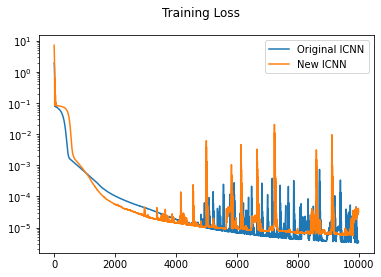

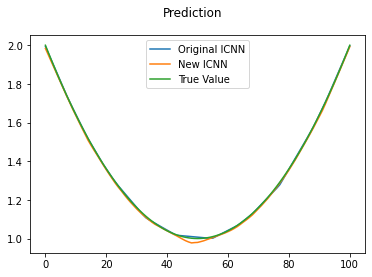

In [29]:
model1 = test1().to(DEVICE)
model2 = test2().to(DEVICE)
loss_traj1 = train_model(model1)
loss_traj2 = train_model(model2)
fig, axes = plt.subplots(1, 1)
axes.plot(loss_traj1, label='Original ICNN')
axes.plot(loss_traj2, label='New ICNN')
axes.set_yscale('log')
axes.legend()
fig.suptitle('Training Loss')
fig.show()

with torch.no_grad():
    test_pred1 = model1(test_x).cpu().detach().numpy()
    test_pred2 = model2(test_x).cpu().detach().numpy()
    
fig, axes = plt.subplots(1, 1)
axes.plot(test_pred1, label='Original ICNN')
axes.plot(test_pred2, label='New ICNN')
axes.plot(test_y, label='True Value')
axes.legend()
fig.suptitle('Prediction')
fig.show()
